In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
train = pd.read_csv('../data/train_data.csv')
test = pd.read_csv('../data/test_data.csv')
data = pd.concat([train, test])

In [3]:
data

,air_inflow,air_end_temp,out_pressure,motor_current,motor_rpm,motor_temp,motor_vibe,type
0,1.59,41.00,0.7,20.53,1680.0,58.67,2.93,0
1,2.97,59.28,0.7,38.40,3142.0,74.91,3.75,0
2,1.91,45.29,0.7,24.73,2023.0,62.48,3.12,0
3,2.37,51.33,0.7,30.63,2506.0,67.84,3.39,0
4,1.90,45.21,0.7,24.65,2017.0,62.41,3.12,0
...,...,...,...,...,...,...,...,...
7384,2.12,48.08,0.7,27.45,2246.0,64.96,3.25,7
7385,1.48,39.63,0.7,19.19,1570.0,57.44,2.87,7
7386,1.56,40.61,0.7,20.15,1649.0,58.32,2.92,7
7387,1.59,40.99,0.7,20.52,1679.0,58.66,2.93,7


In [4]:
type = data['type']

In [5]:
data.drop(['type'], axis=1, inplace=True)

In [6]:
from sklearn.preprocessing import MinMaxScaler
from minisom import MiniSom

In [7]:
sc = MinMaxScaler(feature_range = (0,1))
som_train_data = sc.fit_transform(data)
pd.DataFrame(som_train_data)

,0,1,2,3,4,5,6
0,0.213198,0.267681,1.0,0.221235,0.203046,0.259444,0.048241
1,0.446701,0.813190,1.0,0.481503,0.821489,0.766469,0.089447
2,0.267343,0.395703,1.0,0.282406,0.348139,0.378395,0.057789
3,0.345178,0.575947,1.0,0.368337,0.552453,0.545738,0.071357
4,0.265651,0.393315,1.0,0.281241,0.345601,0.376210,0.057789
...,...,...,...,...,...,...,...
9847,0.302876,0.478962,1.0,0.322022,0.442470,0.455823,0.064322
9848,0.194585,0.226798,1.0,0.201719,0.156514,0.221043,0.045226
9849,0.208122,0.256043,1.0,0.215701,0.189932,0.248517,0.047739
9850,0.213198,0.267383,1.0,0.221089,0.202623,0.259132,0.048241


In [8]:
som = MiniSom(2, 1, input_len=7, sigma=1, neighborhood_function='gaussian', learning_rate=0.01, random_seed=42)
som.random_weights_init(som_train_data)

c:\Users\Root\dacon\AiSparkChallenge4th-3\.conda\lib\site-packages\minisom.py:162: UserWarning: Warning: sigma is too high for the dimension of the map.
  warn('Warning: sigma is too high for the dimension of the map.')


In [9]:
som.train(som_train_data, 1000000, random_order=True, verbose=True)

 [ 1000000 / 1000000 ] 100% - 0:00:00 left 
 quantization error: 0.2894107153902387


In [10]:
outlier_percentage = 0.07
quantization_errors = np.linalg.norm(som.quantization(som_train_data) - som_train_data, axis=1)
error_threshold = np.percentile(quantization_errors, 
                               100*(1-outlier_percentage)+0.01)
is_anomaly = quantization_errors > error_threshold

Text(0, 0.5, 'frequency')

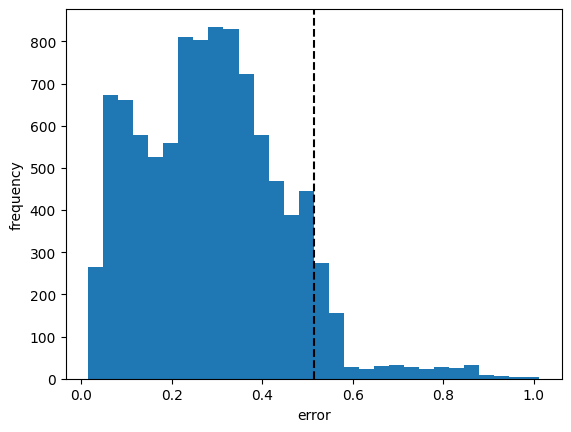

In [11]:
plt.hist(quantization_errors, bins=30)
plt.axvline(error_threshold, color='k', linestyle='--')
plt.xlabel('error')
plt.ylabel('frequency')

In [12]:
label = []
for i in range(len(is_anomaly)):
    if is_anomaly[i] == True:
        label.append(1)
    else:
        label.append(0)

In [22]:
sub = pd.read_csv("../data/answer_sample.csv")
sub['label'] = label[len(train):]

In [25]:
sub.to_csv("../results/som_submission.csv", index=False)

In [16]:
from sklearn.metrics import precision_score, recall_score, f1_score

In [49]:
precision = precision_score(y, label, average='binary')
recall = recall_score(y, label, average='binary')
f1 = f1_score(y, label, average='binary')

In [50]:
precision, recall, f1

(0.33714285714285713, 0.23983739837398374, 0.28028503562945367)

In [20]:
from sklearn.metrics import confusion_matrix

In [52]:
tn, fp, fn, tp = confusion_matrix(y, label).ravel()

In [53]:
tn, fp, fn, tp

(284083, 232, 374, 118)

**Isolation Forest**

In [37]:
from sklearn.ensemble import IsolationForest

In [38]:
train = som_train_data[:200000]
test = som_train_data[200000:]

In [66]:
train_y = data['Class'][:200000]
test_y = data['Class'][200000:]

In [39]:
n_estimators = 400
clf = IsolationForest(random_state=0, n_estimators=n_estimators).fit(train)

In [40]:
result = clf.predict(test)

In [41]:
result = pd.DataFrame(result)
result.replace(to_replace=1, value=0, inplace=True)
result.replace(to_replace=-1, value=1, inplace=True)

In [43]:
precision = precision_score(test_y, result, average='binary')
recall = recall_score(test_y, result, average='binary')
f1 = f1_score(test_y, result, average='binary')

In [44]:
precision, recall, f1

(0.025757575757575757, 0.794392523364486, 0.049897270325799825)

In [45]:
tn, fp, fn, tp = confusion_matrix(y1, result).ravel()

In [46]:
tn, fp, fn, tp

(81485, 3215, 22, 85)

**LOF**

In [23]:
from sklearn.neighbors import LocalOutlierFactor

In [24]:
clf = LocalOutlierFactor(n_neighbors=100)

In [25]:
result = clf.fit_predict(som_train_data)
result = pd.DataFrame(result)
result.replace(to_replace=1, value=0, inplace=True)
result.replace(to_replace=-1, value=1, inplace=True)

In [26]:
precision = precision_score(y, result, average='binary')
recall = recall_score(y, result, average='binary')
f1 = f1_score(y, result, average='binary')

In [27]:
precision, recall, f1

(0.0032282859338970023, 0.12804878048780488, 0.006297795771479982)

In [28]:
tn, fp, fn, tp = confusion_matrix(y, result).ravel()

In [29]:
tn, fp, fn, tp

(264863, 19452, 429, 63)

**One Class SVM**

In [54]:
from sklearn.svm import OneClassSVM

In [55]:
clf = OneClassSVM(kernel='rbf', gamma='auto', verbose=True).fit(train)

[LibSVM]

In [56]:
result = clf.predict(test)
result = pd.DataFrame(result)
result.replace(to_replace=1, value=0, inplace=True)
result.replace(to_replace=-1, value=1, inplace=True)

In [57]:
precision = precision_score(test_y, result, average='binary')
recall = recall_score(test_y, result, average='binary')
f1 = f1_score(test_y, result, average='binary')

In [58]:
precision, recall, f1

(0.0026712969146520634, 0.9345794392523364, 0.005327366682648766)

In [60]:
tn, fp, fn, tp = confusion_matrix(test_y, result).ravel()

In [61]:
tn, fp, fn, tp

(47365, 37335, 7, 100)

**Gradient Boosting**

In [69]:
from sklearn.ensemble import GradientBoostingClassifier
clf = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0).fit(train, train_y)

In [70]:
result = clf.predict(test)

In [73]:
result = pd.DataFrame(result)

In [74]:
precision = precision_score(test_y, result, average='binary')
recall = recall_score(test_y, result, average='binary')
f1 = f1_score(test_y, result, average='binary')
precision, recall, f1

(0.6835443037974683, 0.5046728971962616, 0.5806451612903225)

**Random Forest**

In [75]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(max_depth=2, random_state=0)
clf.fit(train, train_y)

RandomForestClassifier(max_depth=2, random_state=0)

In [76]:
result = clf.predict(test)

In [78]:
result = pd.DataFrame(result)

In [79]:
precision = precision_score(test_y, result, average='binary')
recall = recall_score(test_y, result, average='binary')
f1 = f1_score(test_y, result, average='binary')
precision, recall, f1

(0.9761904761904762, 0.38317757009345793, 0.5503355704697986)